No valid card contour found. Using edge bounding box.


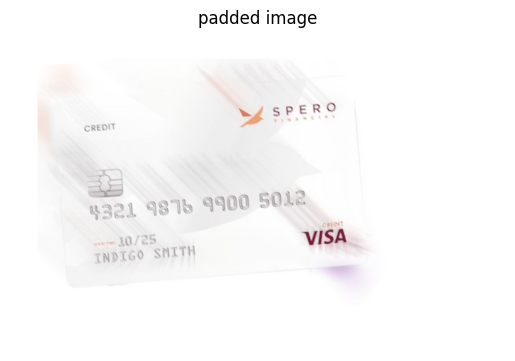

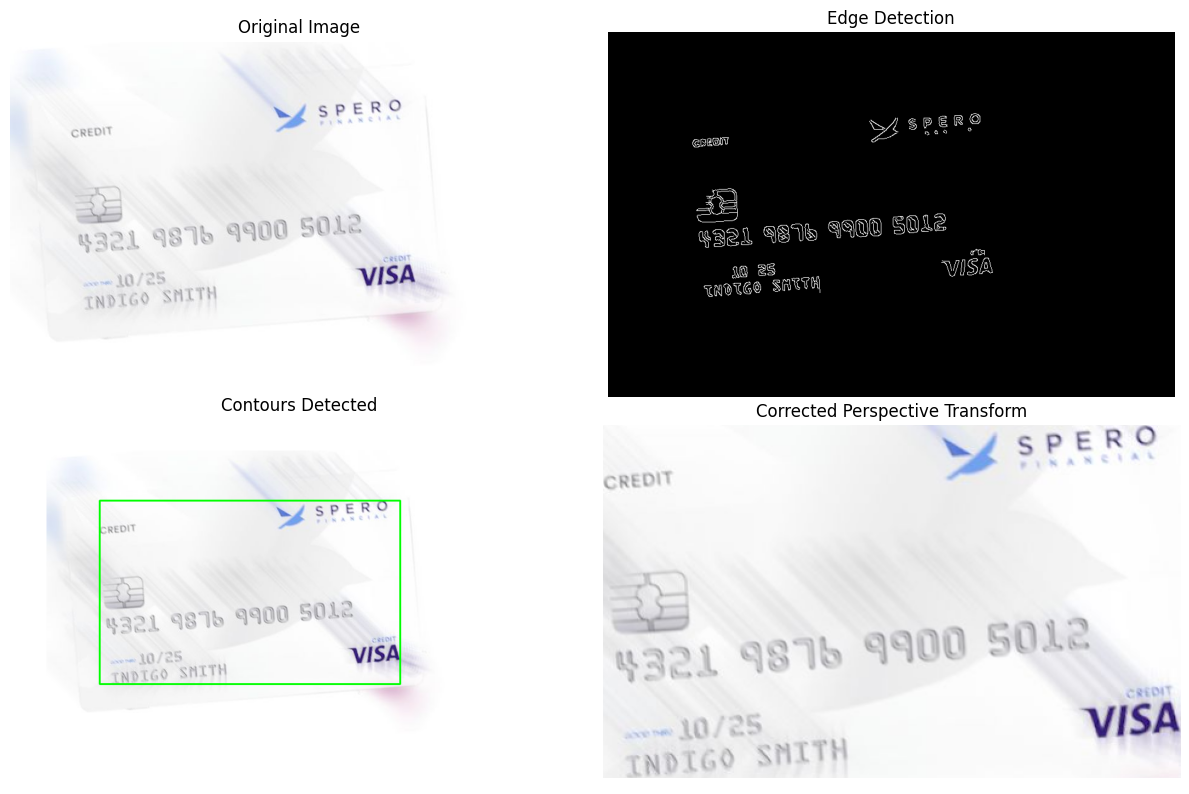

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('09 - El spero spathis we23et 3aaaa.jpg')

pad_size = 50

# Pad the image with white color (255)
padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, 
                                  cv2.BORDER_CONSTANT, value=[255, 255, 255])
plt.imshow(padded_image)
plt.title('padded image')
plt.axis('off')

gray = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)

# Preprocess the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Detect contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def find_card_contour(contours):
    # Iterate over contours and find the one with 4 points and is rectangular
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:  # Check if it's a quadrilateral and area is significant
            return approx
    return None

# Find card contour
approx = find_card_contour(contours)

if approx is None:
    print("No valid card contour found. Using edge bounding box.")
    # Find bounding box of edges
    x, y, w, h = cv2.boundingRect(edges)
    approx = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")

# Ensure there are exactly 4 points
if len(approx) != 4:
    print("Detected contour does not have exactly 4 points. Using fallback.")
    # Fallback to using detected edges bounding box if no valid contour
    x, y, w, h = cv2.boundingRect(edges)
    approx = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")

# Sort the points to ensure correct order (top-left, top-right, bottom-right, bottom-left)
def order_points(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    ordered_pts = np.zeros((4, 2), dtype="float32")
    ordered_pts[0] = pts[np.argmin(s)]
    ordered_pts[2] = pts[np.argmax(s)]
    ordered_pts[1] = pts[np.argmin(diff)]
    ordered_pts[3] = pts[np.argmax(diff)]
    return ordered_pts

# Ordered points
ordered_approx = order_points(approx.reshape(4, 2))

# Perspective Transform
def four_point_transform(image, pts):
    rect = np.array(pts, dtype="float32")
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Perform perspective transform
warped_image = four_point_transform(padded_image, ordered_approx)

# Check orientation and rotate if necessary
def correct_orientation(image):
    (h, w) = image.shape[:2]
    if w < h:
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 90, 1.0)
        rotated = cv2.warpAffine(image, M, (h, w), flags=cv2.INTER_CUBIC)
        return rotated
    return image

# Correct orientation if needed
corrected_image = correct_orientation(warped_image)

# Display results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Contours Detected')
# Draw contours on a copy of the original image
contour_image = padded_image.copy()
if approx is not None:
    approx = np.int32(approx).reshape(-1, 2)  # Ensure the points are integers
    cv2.drawContours(contour_image, [approx], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Corrected Perspective Transform')
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()
